In [2]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install transformers timm scikit-learn matplotlib tqdm

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple, List, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import copy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

from transformers import AutoImageProcessor, ViTForImageClassification


In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cuda')

In [4]:
DATA_ROOT = "./data"

to_tensor = transforms.Compose([transforms.ToTensor()])

full_train = datasets.CIFAR10(root=DATA_ROOT, train=True, transform=to_tensor, download=True)
test_raw   = datasets.CIFAR10(root=DATA_ROOT, train=False, transform=to_tensor, download=True)

len(full_train), len(test_raw), full_train.classes


100%|██████████| 170M/170M [00:15<00:00, 11.1MB/s]


(50000,
 10000,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [5]:
loader = DataLoader(full_train, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
n = 0
mean = torch.zeros(3)
var = torch.zeros(3)
for x, _ in tqdm(loader, desc="Computing mean/std"):
    b = x.size(0)
    n += b
    mean += x.mean(dim=[0,2,3]) * b
    var  += x.var(dim=[0,2,3], unbiased=False) * b

mean /= n
var  /= n
std = torch.sqrt(var)
print("Train mean:", mean.tolist())
print("Train std :", std.tolist())


Computing mean/std: 100%|██████████| 98/98 [00:12<00:00,  7.88it/s]

Train mean: [0.4913996756076813, 0.48215851187705994, 0.4465310275554657]
Train std : [0.2469673752784729, 0.24341857433319092, 0.2614888846874237]


In [6]:
# Validation split
VAL_SIZE = 10_000
TRAIN_SIZE = len(full_train) - VAL_SIZE

# Normalized transforms
train_tf_resnet = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

eval_tf_resnet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

full_train_resnet = datasets.CIFAR10(root=DATA_ROOT, train=True, transform=train_tf_resnet, download=False)
train_set, val_set = random_split(full_train_resnet, [TRAIN_SIZE, VAL_SIZE], generator=torch.Generator().manual_seed(SEED))
test_set_resnet    = datasets.CIFAR10(root=DATA_ROOT, train=False, transform=eval_tf_resnet, download=False)

# Dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set_resnet, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

CLASSES = full_train.classes
print(CLASSES)


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### ResNet-9 Classifer

In [7]:
class ConvBNAct(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, act=nn.ReLU):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = act(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, ch, act=nn.ReLU):
        super().__init__()
        self.conv1 = ConvBNAct(ch, ch, act=act)
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch)
        )
        self.act = act(inplace=True)
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return self.act(out + x)

class ResNet9(nn.Module):
    def __init__(self, num_classes=10, act=nn.ReLU):
        super().__init__()

        self.c1 = ConvBNAct(3,   64, act=act)
        self.c2 = ConvBNAct(64, 128, act=act)
        self.pool1 = nn.MaxPool2d(2)  # 32->16

        self.res1 = nn.Sequential(ResidualBlock(128, act=act), ResidualBlock(128, act=act))

        self.c3 = ConvBNAct(128, 256, act=act)
        self.c4 = ConvBNAct(256, 512, act=act)
        self.pool2 = nn.MaxPool2d(2)  # 16->8

        self.res2 = nn.Sequential(ResidualBlock(512, act=act), ResidualBlock(512, act=act))

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.pool1(x)
        x = self.res1(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.pool2(x)
        x = self.res2(x)
        x = self.head(x)
        return x

m = ResNet9().to(DEVICE)
x = torch.randn(2,3,32,32, device=DEVICE)
m(x).shape


torch.Size([2, 10])

In [8]:
def accuracy_top1(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

@dataclass
class TrainConfig:
    epochs: int = 20
    lr: float = 1e-3
    betas: Tuple[float,float] = (0.9, 0.999)
    log_every: int = 100
    ckpt_path: str = "resnet9_cifar10.pt"

def train_model(model, train_loader, val_loader, cfg: TrainConfig, device=DEVICE):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr, betas=cfg.betas)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

    history = {"train_loss": [], "val_acc": []}
    global_step = 0
    best_val = -1

    for epoch in range(1, cfg.epochs+1):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}")
        for i, (images, labels) in enumerate(pbar, start=1):
            images, labels = images.to(device), labels.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                logits = model(images)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            running += loss.item()
            if i % cfg.log_every == 0:
                avg = running / cfg.log_every
                history["train_loss"].append((global_step, avg))
                pbar.set_postfix(loss=f"{avg:.4f}")
                running = 0.0
            global_step += 1

        # Validation at epoch end
        val_acc = evaluate_accuracy(model, val_loader, device)
        history["val_acc"].append((epoch, val_acc))
        print(f"Validation @ epoch {epoch}: acc = {val_acc:.2f}%")

        if val_acc > best_val:
            best_val = val_acc
            torch.save({"model": model.state_dict(), "val_acc": best_val}, cfg.ckpt_path)
            print(f"  Saved best checkpoint => {cfg.ckpt_path} (val_acc={best_val:.2f}%)")

    return history

def evaluate_accuracy(model, loader, device=DEVICE):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

def load_best(model, path="resnet9_cifar10.pt", device=DEVICE):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])
    return ckpt.get("val_acc", None)


In [9]:
resnet = ResNet9(num_classes=10)
cfg = TrainConfig(epochs=20, lr=1e-3, log_every=100, ckpt_path="resnet9_cifar10.pt")
hist_resnet = train_model(resnet, train_loader, val_loader, cfg, device=DEVICE)


/tmp/ipython-input-2445116194.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
Epoch 1/20:   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipython-input-2445116194.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
Epoch 1/20: 100%|██████████| 1250/1250 [00:47<00:00, 26.14it/s, loss=1.2393]


Validation @ epoch 1: acc = 54.04%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=54.04%)


Epoch 2/20: 100%|██████████| 1250/1250 [00:29<00:00, 43.07it/s, loss=0.9841]


Validation @ epoch 2: acc = 67.43%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=67.43%)


Epoch 3/20: 100%|██████████| 1250/1250 [00:28<00:00, 43.98it/s, loss=0.8075]


Validation @ epoch 3: acc = 72.67%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=72.67%)


Epoch 4/20: 100%|██████████| 1250/1250 [00:31<00:00, 40.27it/s, loss=0.7458]


Validation @ epoch 4: acc = 77.29%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=77.29%)


Epoch 5/20: 100%|██████████| 1250/1250 [00:33<00:00, 36.89it/s, loss=0.6176]


Validation @ epoch 5: acc = 79.93%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=79.93%)


Epoch 6/20: 100%|██████████| 1250/1250 [00:28<00:00, 43.13it/s, loss=0.5645]


Validation @ epoch 6: acc = 80.25%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=80.25%)


Epoch 7/20: 100%|██████████| 1250/1250 [00:29<00:00, 41.82it/s, loss=0.5258]


Validation @ epoch 7: acc = 82.35%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=82.35%)


Epoch 8/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.91it/s, loss=0.4481]


Validation @ epoch 8: acc = 82.06%


Epoch 9/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.92it/s, loss=0.4102]


Validation @ epoch 9: acc = 84.88%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=84.88%)


Epoch 10/20: 100%|██████████| 1250/1250 [00:29<00:00, 41.99it/s, loss=0.3934]


Validation @ epoch 10: acc = 85.17%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=85.17%)


Epoch 11/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.48it/s, loss=0.3674]


Validation @ epoch 11: acc = 85.60%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=85.60%)


Epoch 12/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.82it/s, loss=0.3728]


Validation @ epoch 12: acc = 86.82%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=86.82%)


Epoch 13/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.73it/s, loss=0.3055]


Validation @ epoch 13: acc = 85.93%


Epoch 14/20: 100%|██████████| 1250/1250 [00:29<00:00, 41.90it/s, loss=0.2858]


Validation @ epoch 14: acc = 87.34%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=87.34%)


Epoch 15/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.85it/s, loss=0.2622]


Validation @ epoch 15: acc = 87.19%


Epoch 16/20: 100%|██████████| 1250/1250 [00:28<00:00, 43.14it/s, loss=0.2711]


Validation @ epoch 16: acc = 86.79%


Epoch 17/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.45it/s, loss=0.2367]


Validation @ epoch 17: acc = 88.91%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=88.91%)


Epoch 18/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.06it/s, loss=0.2239]


Validation @ epoch 18: acc = 87.86%


Epoch 19/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.87it/s, loss=0.2104]


Validation @ epoch 19: acc = 88.81%


Epoch 20/20: 100%|██████████| 1250/1250 [00:29<00:00, 42.87it/s, loss=0.1889]


Validation @ epoch 20: acc = 89.04%
  Saved best checkpoint => resnet9_cifar10.pt (val_acc=89.04%)


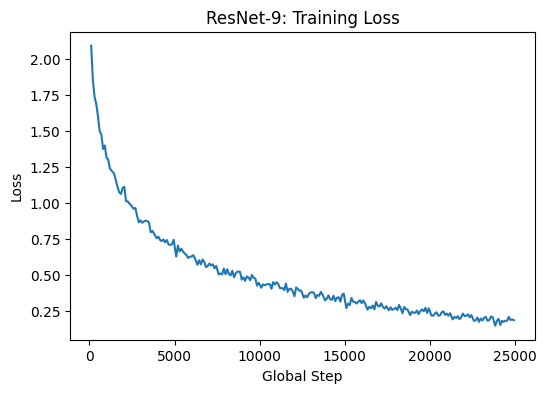

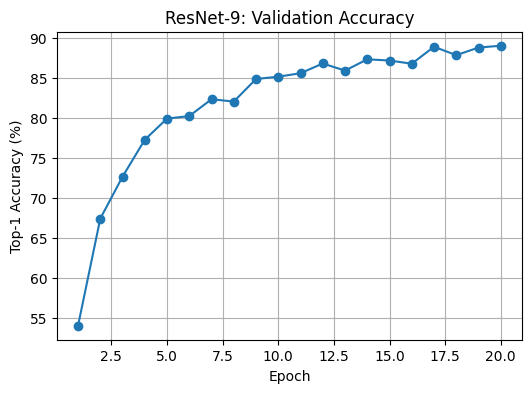

In [10]:
# Loss (per step) and val acc (per epoch)
steps, losses = zip(*hist_resnet["train_loss"]) if hist_resnet["train_loss"] else ([],[])
ep, accs = zip(*hist_resnet["val_acc"]) if hist_resnet["val_acc"] else ([],[])

plt.figure(figsize=(6,4))
plt.plot(steps, losses)
plt.title("ResNet-9: Training Loss")
plt.xlabel("Global Step"); plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(ep, accs, marker='o')
plt.title("ResNet-9: Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Top-1 Accuracy (%)")
plt.grid(True)
plt.show()


Classification report (ResNet-9):

              precision    recall  f1-score   support

    airplane     0.8499    0.9340    0.8899      1000
  automobile     0.9672    0.9130    0.9393      1000
        bird     0.8456    0.8490    0.8473      1000
         cat     0.8307    0.7260    0.7748      1000
        deer     0.8410    0.8990    0.8690      1000
         dog     0.8528    0.8110    0.8314      1000
        frog     0.9039    0.9220    0.9129      1000
       horse     0.8815    0.9520    0.9154      1000
        ship     0.9463    0.9340    0.9401      1000
       truck     0.9393    0.9130    0.9260      1000

    accuracy                         0.8853     10000
   macro avg     0.8858    0.8853    0.8846     10000
weighted avg     0.8858    0.8853    0.8846     10000



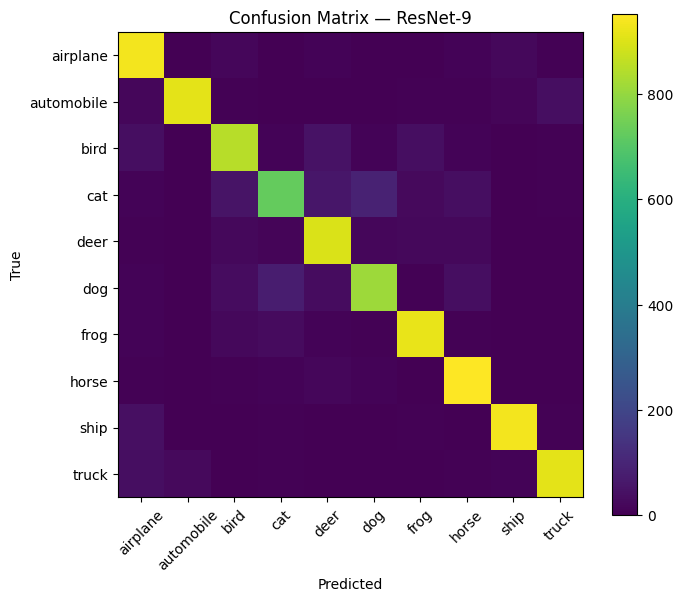

In [11]:
def get_all_preds_labels(model, loader, device=DEVICE):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy().tolist()
            all_preds.extend(preds)
            all_labels.extend(y.numpy().tolist())
    return np.array(all_preds), np.array(all_labels)

preds_r, labels_r = get_all_preds_labels(resnet, test_loader, DEVICE)
cm_r = confusion_matrix(labels_r, preds_r)
print("Classification report (ResNet-9):\n")
print(classification_report(labels_r, preds_r, target_names=CLASSES, digits=4))

plt.figure(figsize=(7,6))
plt.imshow(cm_r, interpolation='nearest')
plt.title("Confusion Matrix — ResNet-9")
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)
plt.tight_layout()
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


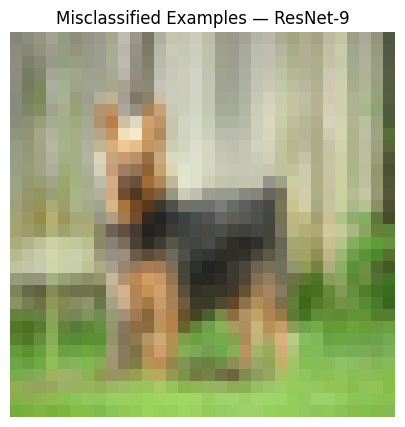

True: dog
Pred: deer 



In [12]:
# Examples for misclassified examples from the test set
denorm = transforms.Normalize(
    mean=(-mean/ std).tolist(),
    std=(1.0/std).tolist()
)

mis_images = []
mis_titles = []

resnet.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        logits = resnet(x)
        preds = logits.argmax(dim=1).cpu()
        y_cpu = y
        wrong = preds.ne(y_cpu)
        if wrong.any():
            idx = torch.where(wrong)[0]
            for i in idx[:8]:  # take up to 8 examples
                img = x[i].cpu()
                img_vis = denorm(img).clamp(0,1)
                mis_images.append(img_vis)
                mis_titles.append(f"True: {CLASSES[y_cpu[i]]}\nPred: {CLASSES[preds[i]]}")
            break

if mis_images:
    grid = make_grid(mis_images, nrow=4)
    plt.figure(figsize=(8,5))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title("Misclassified Examples — ResNet-9")
    plt.axis('off')
    plt.show()
    for t in mis_titles:
        print(t, "\n")


### ViT Classifier - Full and Head-only

In [13]:
VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(VIT_MODEL_NAME)

train_tf_vit = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

eval_tf_vit = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

full_train_vit = datasets.CIFAR10(root=DATA_ROOT, train=True, transform=train_tf_vit, download=False)
train_set_vit, val_set_vit = random_split(full_train_vit, [TRAIN_SIZE, VAL_SIZE], generator=torch.Generator().manual_seed(SEED))
test_set_vit = datasets.CIFAR10(root=DATA_ROOT, train=False, transform=eval_tf_vit, download=False)

train_loader_vit = DataLoader(train_set_vit, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader_vit   = DataLoader(val_set_vit,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_vit  = DataLoader(test_set_vit,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [14]:
vit_full = ViTForImageClassification.from_pretrained(
    VIT_MODEL_NAME,
    num_labels=10,
    ignore_mismatched_sizes=True
).to(DEVICE)

vit_head_only = copy.deepcopy(vit_full)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
@dataclass
class ViTConfig:
    epochs: int = 3
    lr: float = 5e-5
    betas: Tuple[float,float] = (0.9, 0.999)
    log_every: int = 100
    ckpt_path: str = "vit_cifar10_full.pt"

def train_vit(model, train_loader, val_loader, cfg: ViTConfig, device=DEVICE, train_head_only=False):
    model.train()
    if train_head_only:
        # Freeze all layers except classification head
        for p in model.parameters():
            p.requires_grad = False
        for p in model.classifier.parameters():
            p.requires_grad = True

    # Collect only trainable parameters
    params = [p for p in model.parameters() if p.requires_grad]
    opt = torch.optim.AdamW(params, lr=cfg.lr, betas=cfg.betas)
    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

    history = {"train_loss": [], "val_acc": []}
    best_val = -1
    global_step = 0

    for epoch in range(1, cfg.epochs+1):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, desc=f"ViT Epoch {epoch}/{cfg.epochs}" + (" (head only)" if train_head_only else " (full)"))
        for i, (images, labels) in enumerate(pbar, start=1):
            images, labels = images.to(device), labels.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                out = model(images)
                logits = out.logits
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            running += loss.item()
            if i % cfg.log_every == 0:
                avg = running / cfg.log_every
                history["train_loss"].append((global_step, avg))
                pbar.set_postfix(loss=f"{avg:.4f}")
                running = 0.0
            global_step += 1

        val_acc = evaluate_vit_accuracy(model, val_loader, device)
        history["val_acc"].append((epoch, val_acc))
        print(f"Validation @ epoch {epoch}: acc = {val_acc:.2f}%")

        if val_acc > best_val:
            best_val = val_acc
            torch.save({"model": model.state_dict(), "val_acc": best_val}, cfg.ckpt_path)
            print(f"  Saved best checkpoint => {cfg.ckpt_path} (val_acc={best_val:.2f}%)")

    return history

def evaluate_vit_accuracy(model, loader, device=DEVICE):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x).logits
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

def load_best_vit(model, path, device=DEVICE):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])
    return ckpt.get("val_acc", None)


In [16]:
vit_cfg_full = ViTConfig(epochs=3, lr=5e-5, ckpt_path="vit_cifar10_full.pt")
hist_vit_full = train_vit(vit_full, train_loader_vit, val_loader_vit, vit_cfg_full, DEVICE, train_head_only=False)


/tmp/ipython-input-3288119804.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
ViT Epoch 1/3 (full):   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipython-input-3288119804.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
ViT Epoch 1/3 (full): 100%|██████████| 1250/1250 [05:30<00:00,  3.78it/s, loss=0.0973]


Validation @ epoch 1: acc = 97.61%
  Saved best checkpoint => vit_cifar10_full.pt (val_acc=97.61%)


ViT Epoch 2/3 (full): 100%|██████████| 1250/1250 [05:29<00:00,  3.79it/s, loss=0.0438]


Validation @ epoch 2: acc = 97.80%
  Saved best checkpoint => vit_cifar10_full.pt (val_acc=97.80%)


ViT Epoch 3/3 (full): 100%|██████████| 1250/1250 [05:28<00:00,  3.80it/s, loss=0.0256]


Validation @ epoch 3: acc = 98.31%
  Saved best checkpoint => vit_cifar10_full.pt (val_acc=98.31%)


In [17]:
vit_cfg_head = ViTConfig(epochs=3, lr=5e-4, ckpt_path="vit_cifar10_head_only.pt")
hist_vit_head = train_vit(vit_head_only, train_loader_vit, val_loader_vit, vit_cfg_head, DEVICE, train_head_only=True)


/tmp/ipython-input-3288119804.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
ViT Epoch 1/3 (head only):   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipython-input-3288119804.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
ViT Epoch 1/3 (head only): 100%|██████████| 1250/1250 [01:43<00:00, 12.05it/s, loss=0.1505]


Validation @ epoch 1: acc = 96.06%
  Saved best checkpoint => vit_cifar10_head_only.pt (val_acc=96.06%)


ViT Epoch 2/3 (head only): 100%|██████████| 1250/1250 [01:42<00:00, 12.20it/s, loss=0.1266]


Validation @ epoch 2: acc = 96.33%
  Saved best checkpoint => vit_cifar10_head_only.pt (val_acc=96.33%)


ViT Epoch 3/3 (head only): 100%|██████████| 1250/1250 [01:42<00:00, 12.22it/s, loss=0.1071]


Validation @ epoch 3: acc = 96.43%
  Saved best checkpoint => vit_cifar10_head_only.pt (val_acc=96.43%)


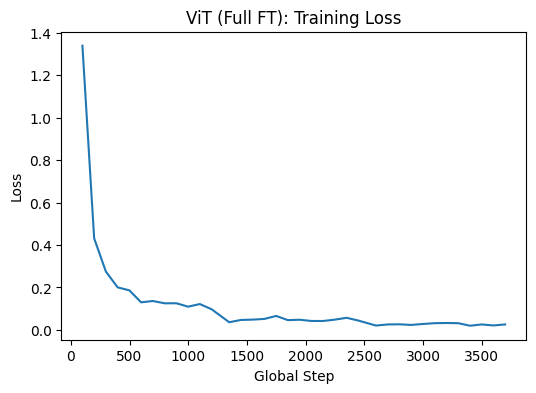

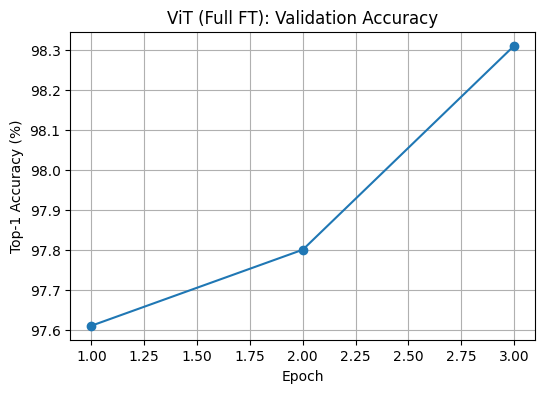

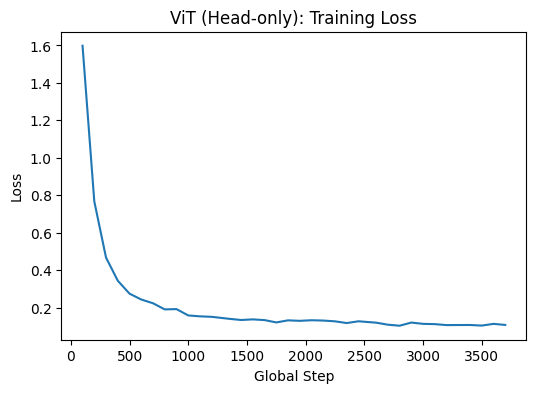

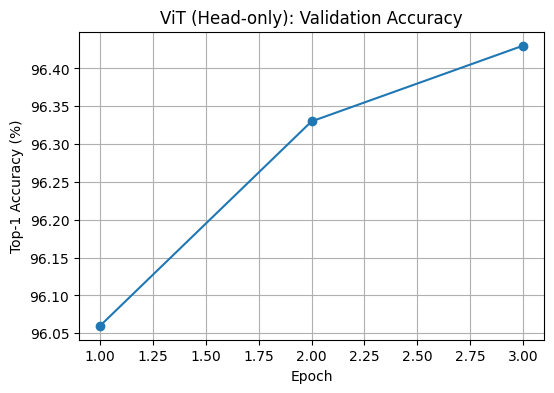

In [18]:
def plot_hist(hist, title_prefix="ViT"):
    if hist["train_loss"]:
        s,l = zip(*hist["train_loss"])
        plt.figure(figsize=(6,4))
        plt.plot(s,l)
        plt.title(f"{title_prefix}: Training Loss")
        plt.xlabel("Global Step"); plt.ylabel("Loss")
        plt.show()
    if hist["val_acc"]:
        e,a = zip(*hist["val_acc"])
        plt.figure(figsize=(6,4))
        plt.plot(e,a, marker='o')
        plt.title(f"{title_prefix}: Validation Accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Top-1 Accuracy (%)")
        plt.grid(True)
        plt.show()

plot_hist(hist_vit_full, "ViT (Full FT)")
plot_hist(hist_vit_head, "ViT (Head-only)")


In [19]:
best_val_full = load_best_vit(vit_full, "vit_cifar10_full.pt", DEVICE)
best_val_head = load_best_vit(vit_head_only, "vit_cifar10_head_only.pt", DEVICE)
print(f"Best Val (ViT Full): {best_val_full:.2f}%")
print(f"Best Val (ViT Head): {best_val_head:.2f}%")

def vit_test_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x).logits
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

test_acc_full = vit_test_accuracy(vit_full, test_loader_vit)
test_acc_head = vit_test_accuracy(vit_head_only, test_loader_vit)

print(f"ViT Full Test Accuracy: {test_acc_full:.2f}%")
print(f"ViT Head-only Test Accuracy: {test_acc_head:.2f}%")


Best Val (ViT Full): 98.31%
Best Val (ViT Head): 96.43%
ViT Full Test Accuracy: 97.93%
ViT Head-only Test Accuracy: 96.40%


Classification report (ViT Full):

              precision    recall  f1-score   support

    airplane     0.9899    0.9770    0.9834      1000
  automobile     0.9783    0.9920    0.9851      1000
        bird     0.9908    0.9700    0.9803      1000
         cat     0.9514    0.9600    0.9557      1000
        deer     0.9762    0.9850    0.9806      1000
         dog     0.9636    0.9530    0.9583      1000
        frog     0.9930    0.9950    0.9940      1000
       horse     0.9755    0.9960    0.9857      1000
        ship     0.9900    0.9870    0.9885      1000
       truck     0.9849    0.9780    0.9814      1000

    accuracy                         0.9793     10000
   macro avg     0.9794    0.9793    0.9793     10000
weighted avg     0.9794    0.9793    0.9793     10000



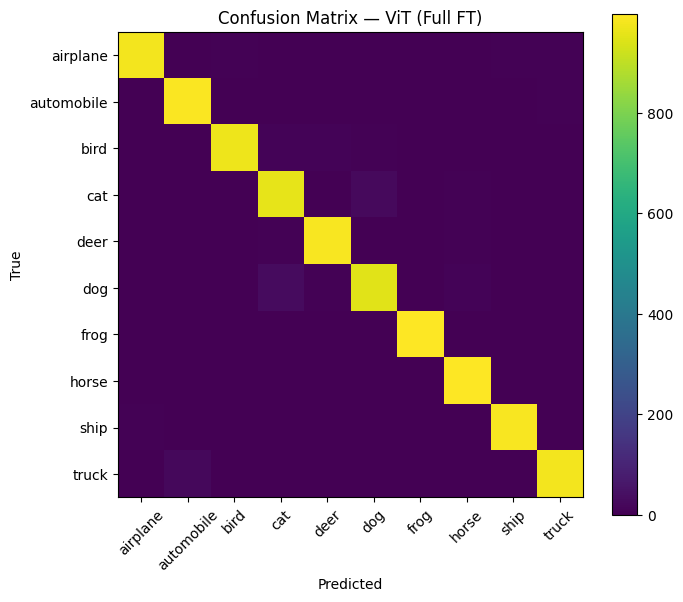

In [20]:
def vit_preds_labels(model, loader):
    model.eval()
    P,L = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE)
            logits = model(x).logits
            P.extend(logits.argmax(dim=1).cpu().numpy().tolist())
            L.extend(y.numpy().tolist())
    return np.array(P), np.array(L)

preds_vit, labels_vit = vit_preds_labels(vit_full, test_loader_vit)
cm_vit = confusion_matrix(labels_vit, preds_vit)
print("Classification report (ViT Full):\n")
print(classification_report(labels_vit, preds_vit, target_names=CLASSES, digits=4))

plt.figure(figsize=(7,6))
plt.imshow(cm_vit, interpolation='nearest')
plt.title("Confusion Matrix — ViT (Full FT)")
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)
plt.tight_layout()
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


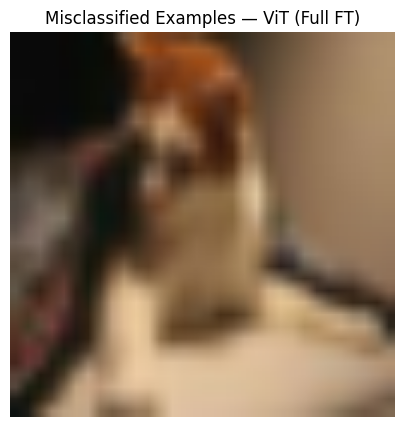

True: cat
Pred: dog 



In [21]:
vit_denorm = transforms.Normalize(
    mean=(-torch.tensor(processor.image_mean)/ torch.tensor(processor.image_std)).tolist(),
    std=(1.0/ torch.tensor(processor.image_std)).tolist()
)

mis_images = []
mis_titles = []

vit_full.eval()
with torch.no_grad():
    for x, y in test_loader_vit:
        x = x.to(DEVICE)
        logits = vit_full(x).logits
        preds = logits.argmax(dim=1).cpu()
        y_cpu = y
        wrong = preds.ne(y_cpu)
        if wrong.any():
            idx = torch.where(wrong)[0]
            for i in idx[:8]:
                img = x[i].cpu()
                img_vis = vit_denorm(img).clamp(0,1)
                mis_images.append(img_vis)
                mis_titles.append(f"True: {CLASSES[y_cpu[i]]}\nPred: {CLASSES[preds[i]]}")
            break

if mis_images:
    grid = make_grid(mis_images, nrow=4)
    plt.figure(figsize=(8,5))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title("Misclassified Examples — ViT (Full FT)")
    plt.axis('off')
    plt.show()
    for t in mis_titles:
        print(t, "\n")
